# Recomend Album Based on Embeddings

In [1]:
%run ./wikipedia_setup.ipynb

In [2]:
import gensim
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.neighbors import KDTree
from sklearn.cluster import AgglomerativeClustering

In [3]:
pd.set_option('display.max_rows', 100)

## Configure DB & Load Model

In [4]:
db = sqlite3.Connection("var/data/music.db")

In [5]:
doc_model = Doc2Vec.load("var/models/album_detail_model.d2v")

2021-10-31 15:28:07,470 - gensim.utils - INFO - loading Doc2Vec object from var/models/album_detail_model.d2v
2021-10-31 15:28:07,718 - gensim.utils - INFO - loading dv recursively from var/models/album_detail_model.d2v.dv.* with mmap=None
2021-10-31 15:28:07,723 - gensim.utils - INFO - loading wv recursively from var/models/album_detail_model.d2v.wv.* with mmap=None
2021-10-31 15:28:07,726 - gensim.utils - INFO - setting ignored attribute cum_table to None
2021-10-31 15:28:08,996 - gensim.utils - INFO - Doc2Vec lifecycle event {'fname': 'var/models/album_detail_model.d2v', 'datetime': '2021-10-31T15:28:08.995337', 'gensim': '4.1.2', 'python': '3.7.6 (tags/v3.7.6:43364a7ae0, Dec 19 2019, 00:42:30) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'loaded'}


## Load Albums + Embeddings

In [27]:
albums = pd.read_sql(f"""
  select
    ayl.Artist,
    ayl.Album,
    ayl.Genre,
    ayl.Label,
    ayl.Year,
    adl.AlbumDetailTextLength,
    ae.DetailEmbedding
  from wp_albums_year_lists ayl
  left join (
    select Artist, Album, length(AlbumDetailText) as AlbumDetailTextLength
    from album_detail_text
  ) adl on (
    ayl.Artist = adl.Artist and
    ayl.Album = adl.Album
  )
  left join album_embedding ae on (
    ayl.Artist = ae.Artist and
    ayl.Album = ae.Album
  )
""", db)

def parse_embedding(de):
    if de is None or de == '':
        return None
    
    return np.array(list(map(float, de.split(","))))

albums['DetailEmbedding'] = albums.DetailEmbedding.apply(parse_embedding)
albums['AlbumDetailTextLength'] = albums['AlbumDetailTextLength'].fillna(0.0)

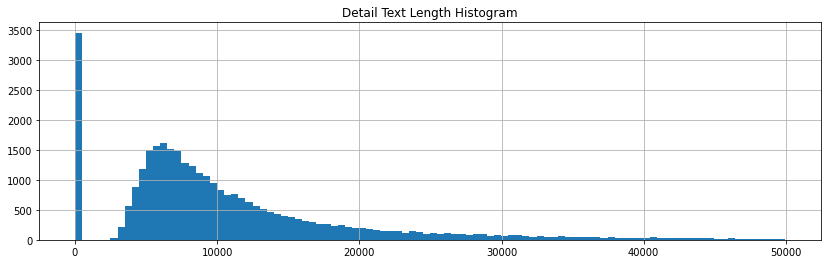

,AlbumDetailTextLength
count,33059.000000
mean,12010.211107
std,13300.349963
min,0.000000
25%,5629.000000
50%,8488.000000
75%,13922.500000
max,224394.000000


In [34]:
plt.figure(figsize=(14, 4))
plt.grid(1)
plt.title("Detail Text Length Histogram")
albums.AlbumDetailTextLength[albums.AlbumDetailTextLength < 50000].hist(bins=100)
plt.show()

display(albums['AlbumDetailTextLength'].describe().to_frame())

In [44]:
# Filter out to albums with enough descriptive text written about them.
albums_w_sig_desc = albums[albums['AlbumDetailTextLength'] >= 8000]

# Drop duplicates
albums_w_sig_desc = albums_w_sig_desc.sort_values(by=['Artist', 'Album']).drop_duplicates(['Artist', 'Album'])
albums_w_sig_desc

,Artist,Album,Genre,Label,Year,AlbumDetailTextLength,DetailEmbedding
11819,!!!,Myth Takes,Dance-punk,Warp,2007,8974.0,"[0.04985291, 0.0879841, 0.061455175, 0.4089145..."
26233,"""Weird Al"" Yankovic","""Weird Al"" Yankovic",None,None,1983,25141.0,"[1.7772075, 1.4750017, -0.7580228, 0.22363527,..."
25849,"""Weird Al"" Yankovic","""Weird Al"" Yankovic in 3-D",None,None,1984,29334.0,"[0.5802811, 0.51073235, -1.7187734, -1.05255, ..."
22929,"""Weird Al"" Yankovic",Alapalooza,None,None,1993,24507.0,"[1.8789082, 1.1626757, -0.38504604, -0.0605782..."
26840,"""Weird Al"" Yankovic",Another One Rides the Bus,None,None,1981,12497.0,"[1.474934, 1.4581908, -0.99372715, 0.08401047,..."
...,...,...,...,...,...,...,...
24487,various artists,Shocker,None,None,1989,15154.0,"[1.3667016, -0.83163846, 4.0431604, -1.1203645..."
8058,will.i.am,#willpower,"Hip hop, dance-pop","will.i.am, Interscope",2013,36898.0,"[1.258637, -2.6308014, 0.7052187, -0.097950466..."
12321,will.i.am,Songs About Girls,"Hip hop, electronic, R&B","will.i.am, Interscope",2007,16205.0,"[1.8424009, -1.4908918, -0.91329926, -0.891332..."
13347,…And You Will Know Us by the Trail of Dead,So Divided,"Alternative rock, progressive rock",Interscope,2006,14049.0,"[-1.3201139, 0.5830331, 1.5385767, -0.8845727,..."


## Find Neighbors For Albums

Use a KDTree to find artist close to others.

In [45]:
# Create a KDTree over embeddings to search
alb_emb = np.vstack(albums_w_sig_desc.DetailEmbedding)
alb_neighbors = KDTree(alb_emb)

In [73]:
def get_similar_albums(album, n):
    s_album = albums_w_sig_desc[albums_w_sig_desc.Album == album]
    if len(s_album) == 0:
        print(f"Warning: no albums found for {album}.")
        return None
    
    s_album = s_album.iloc[0]
    n_distances, neighbors = alb_neighbors.query(s_album.DetailEmbedding.reshape(1, -1), k=n)

    neighbor_rows = albums_w_sig_desc.iloc[neighbors[0]].copy()
    neighbor_rows['Distance'] = n_distances[0]
    return neighbor_rows

In [66]:
test_albums = [
    "Flying Microtonal Banana",
    "Hot Rats",
    "OK Computer",
    "To Pimp a Butterfly",
    "The Fragile",
    "Under the Pink",
    "RTJ4",
    "Lateralus"
]

test_albums = albums_w_sig_desc[albums_w_sig_desc.Album.isin(test_albums)]

In [85]:
for _, ta in test_albums.iterrows():
    
    # Show 10 similar albums not from the same artist/group.
    
    display(HTML((f"<h2>{ta.Artist} - {ta.Album}</h2>")))
    sim_albums = get_similar_albums(ta.Album, 50)
    sim_albums = sim_albums[sim_albums.Artist != ta.Artist]
    
    if len(sim_albums) > 10:
        sim_albums = sim_albums.sample(10)
    
    display(sim_albums)
    

,Artist,Album,Genre,Label,Year,AlbumDetailTextLength,DetailEmbedding,Cluster,Distance
22677,The Mothers of Invention,Ahead of Their Time,None,None,1993,8873.0,"[-0.46706632, -0.7017966, -1.4694542, -0.36609...",27,5.695456
30895,The Mothers of Invention,Uncle Meat,None,None,1969,21440.0,"[-0.77729106, -0.8784948, -0.03503441, -1.0139...",27,7.038776
26714,Captain Beefheart,Ice Cream for Crow,None,None,1982,10381.0,"[0.23239219, -0.91212636, -1.2527578, -0.44744...",77,6.858220
28117,Captain Beefheart,Shiny Beast (Bat Chain Puller),None,None,1978,11224.0,"[0.22627412, -0.58292896, -0.6350362, -0.73143...",77,7.134904
29867,Frank Zappa and The Mothers,Just Another Band from L.A.,None,None,1972,8972.0,"[0.1222059, -0.5247738, -1.6004847, 0.33620048...",27,6.055104
30870,The Mothers of Invention,Mothermania,None,None,1969,12923.0,"[0.7374683, -0.5294273, -0.7195152, -0.2587755...",27,6.298538
29028,Frank Zappa & The Mothers of Invention with Ca...,Bongo Fury,None,None,1975,11987.0,"[-0.379964, -0.89630026, -0.89148384, -0.95306...",27,5.955381
23411,Frank Zappa and The Mothers of Invention,Playground Psychotics,None,None,1992,10135.0,"[0.1950603, 0.009489866, -0.75995857, 0.058666...",27,5.833627
30332,The Mothers of Invention,Fillmore East – June 1971,None,None,1971,12082.0,"[0.6878961, -0.84968024, -1.049568, -0.5296461...",27,5.647879
28924,Frank Zappa and The Mothers of Invention,One Size Fits All,None,None,1975,11899.0,"[0.3709318, -0.080543235, -1.3119388, -1.02242...",27,6.111988


,Artist,Album,Genre,Label,Year,AlbumDetailTextLength,DetailEmbedding,Cluster,Distance
12258,Kanye West,Graduation,Hip hop,Roc-A-Fella,2007,139907.0,"[-1.7592821, -1.6955495, 2.9475918, 0.03308288...",50,7.528920
221,Nas,King's Disease II,,Mass Appeal,2021,15162.0,"[0.75305146, -2.8674135, 2.8327332, -0.7691642...",44,8.709076
8854,Nas,Life Is Good,Hip hop,Def Jam,2012,42333.0,"[2.1847928, -1.3748919, 1.5316048, 0.29449192,...",82,9.333449
5325,2 Chainz,Pretty Girls Like Trap Music,"Hip hop, trap",Def Jam,2017,36782.0,"[3.8784256, -1.6949955, 1.7321587, -1.9613094,...",44,9.667016
8973,Lupe Fiasco,Food & Liquor II: The Great American Rap Album...,Hip hop,Atlantic,2012,24802.0,"[1.9293413, -3.125306, 3.3822026, -0.8772504, ...",66,9.781784
13143,Lupe Fiasco,Lupe Fiasco's Food & Liquor,Hip hop,"1st & 15th, Atlantic",2006,28867.0,"[2.368469, -2.7336335, 2.7218425, 0.19062752, ...",66,9.297146
4377,Pusha T,Daytona,Hip hop,"GOOD, Def Jam",2018,34458.0,"[2.4122655, -2.2627437, 2.9937325, -2.495198, ...",50,7.737345
11710,Kanye West,808s & Heartbreak,,,2008,86865.0,"[-0.48932827, -0.69325316, 2.961576, -0.455816...",50,6.698422
4641,Meek Mill,Championships,Hip hop,"Atlantic, Maybach Music",2018,28947.0,"[1.0518291, -1.2095304, 2.9021637, -2.0290656,...",44,8.959668
10074,Kanye West,My Beautiful Dark Twisted Fantasy,Hip hop,"Def Jam, Roc-A-Fella",2010,107970.0,"[0.7671705, -1.4771904, 2.180657, -1.2214836, ...",50,6.643303


,Artist,Album,Genre,Label,Year,AlbumDetailTextLength,DetailEmbedding,Cluster,Distance
21321,Kula Shaker,K,None,None,1996,11627.0,"[0.066563785, 0.10495242, -1.349966, -0.798492...",16,7.380615
24419,Ray Lynch,No Blue Thing,None,None,1989,8384.0,"[-1.5416658, 0.13134491, -1.1905133, 0.8173904...",26,7.259511
6483,Periphery,Juggernaut: Alpha,Progressive metal,Sumerian,2015,8591.0,"[-1.8386137, -1.2497473, -0.219681, -1.2719465...",12,6.774812
9834,Minus the Bear,Omni,,,2010,8247.0,"[0.85575414, 1.4948907, -0.55006874, -0.192780...",31,7.075060
6038,Kaleo,A/B,"Indie folk, garage rock, Americana",Elektra,2016,11301.0,"[-2.1912165, -0.34665355, -0.18560545, 0.15645...",31,7.006963
31281,John Mayall,Blues from Laurel Canyon,None,None,1968,9372.0,"[-1.6135511, 0.32675022, -1.9037607, -0.498863...",52,6.974348
2841,Touché Amoré,Lament,,Epitaph,2020,9148.0,"[-0.8985118, -0.31355143, -0.30750653, 1.63270...",31,7.308491
3460,Big Thief,U.F.O.F.,"Indie rock, folk rock",4AD,2019,10633.0,"[-1.1201428, 0.22592089, 0.34656352, 0.1204620...",31,6.749820
2343,Jeff Rosenstock,No Dream,,"Quote Unquote, Polyvinyl",2020,11120.0,"[-0.7495792, 0.5773761, -0.7319593, -0.1134516...",77,7.307788
4138,Burial,Tunes 2011–2019,,Hyperdub,2019,8276.0,"[-1.1679791, 0.8802525, 0.98080033, -0.4894261...",54,6.812776


,Artist,Album,Genre,Label,Year,AlbumDetailTextLength,DetailEmbedding,Cluster,Distance
8676,Ian Anderson,Thick as a Brick 2,Progressive rock,"Chrysalis, EMI",2012,12811.0,"[-1.5423684, -0.2166668, -0.39036193, 0.796783...",16,9.236388
11128,Foals,Antidotes,"Indie rock, math rock, dance-punk","Transgressive, Sub Pop",2008,10075.0,"[-1.3166146, 1.1590666, -0.36396194, 0.4160312...",53,8.996884
1820,King Gizzard & the Lizard Wizard,Butterfly 3000,,,2021,12680.0,"[0.38182092, 0.47946286, 0.6170254, 1.1381345,...",74,9.074701
4249,Andrew W.K.,You're Not Alone,Hard rock,"RED, Sony Music",2018,9292.0,"[-0.027583556, 0.44483244, 0.7287063, -0.36822...",54,8.948992
24727,Killing Joke,Outside the Gate,None,None,1988,12093.0,"[0.048850957, 0.2444091, 0.25468412, 0.4448479...",25,9.276348
17393,Tool,Lateralus,None,None,2001,31849.0,"[0.791097, 0.24396306, -0.7697912, -0.5729901,...",48,8.886738
12995,Agalloch,Ashes Against the Grain,"Post-metal, folk metal, black metal",The End,2006,12046.0,"[-0.19259556, -1.019, 0.22169106, 0.44384724, ...",12,8.671407
9244,Between the Buried and Me,The Parallax: Hypersleep Dialogues,"Progressive metal, technical death metal, avan...",Metal Blade,2011,12395.0,"[0.38309482, -0.03079536, 0.09020787, 0.597241...",12,9.126492
13446,…And You Will Know Us by the Trail of Dead,Worlds Apart,"Alternative rock, art rock, indie rock",Interscope,2005,17514.0,"[-0.29787216, -0.49798918, -0.5255117, -1.8777...",12,8.729050
10797,The Flaming Lips,Embryonic,"Neo-psychedelia, psychedelic rock, space rock",Warner Bros.,2009,15484.0,"[0.39252636, 0.31307578, 0.17018382, 0.3650682...",54,8.578809


,Artist,Album,Genre,Label,Year,AlbumDetailTextLength,DetailEmbedding,Cluster,Distance
4635,The 1975,A Brief Inquiry into Online Relationships,"Pop, rock, electropop","Dirty Hit, Polydor",2018,94639.0,"[-0.5609728, 0.7278163, -1.5031097, 0.4347976,...",54,10.604395
7677,Thom Yorke,Tomorrow's Modern Boxes,Electronica,,2014,24100.0,"[-0.5536672, 0.45854846, -0.26803592, -0.09272...",69,9.605004
11453,Late of the Pier,Fantasy Black Channel,,,2008,30731.0,"[-2.0907593, 2.5305696, 0.17002775, 1.3461573,...",30,10.508355
17482,Muse,Origin of Symmetry,None,None,2001,25284.0,"[-2.8276834, -0.60914254, 0.08397364, -0.05491...",69,10.500411
22397,Manic Street Preachers,The Holy Bible,None,None,1994,46873.0,"[-0.912912, -0.10890954, -1.889025, 0.44525987...",30,10.439705
12934,Thom Yorke,The Eraser,"Electronica, alternative rock",XL,2006,29663.0,"[-0.92654383, -0.05066835, -0.69951594, 0.7561...",69,8.022428
19115,Super Furry Animals,Guerrilla,None,None,1999,39528.0,"[-2.2741861, 0.67180747, -1.3479383, -1.6332, ...",30,10.261217
2230,EOB,Earth,,Capitol,2020,15999.0,"[-1.5066384, 0.87199235, -0.7768596, 1.0085509...",54,10.635502
26185,Pink Floyd,The Final Cut,None,None,1983,42781.0,"[-1.5830626, 0.7257841, 1.6341285, -0.07534969...",34,10.637623
7709,Philip Selway,Weatherhouse,Art rock,Bella Union,2014,8794.0,"[-0.6773377, 0.57138723, -0.62552625, 0.710179...",74,10.183086


,Artist,Album,Genre,Label,Year,AlbumDetailTextLength,DetailEmbedding,Cluster,Distance
11544,DJ Khaled,We Global,Hip hop,"We the Best, Terror Squad, Koch",2008,11376.0,"[1.0534815, -0.056208298, 0.48434398, -1.75346...",44,10.026984
6119,DJ Khaled,Major Key,"Hip hop, trap, R&B","Epic, We the Best",2016,28444.0,"[1.7352511, -1.0457042, 1.0299015, -0.29622427...",44,9.958254
13388,Clipse,Hell Hath No Fury,Hip hop,"Re-Up, Star Trak, Jive",2006,21355.0,"[1.7421837, -0.715186, 3.563543, -1.6157153, 1...",49,9.289488
10917,Gucci Mane,The State vs. Radric Davis,"Hip hop, Southern hip hop",,2009,20052.0,"[2.0460057, -0.9723555, 2.6921532, -2.430955, ...",66,9.065221
9117,Talib Kweli,Gutter Rainbows,Alternative hip hop,"Blacksmith Music, Javotti Media",2011,13058.0,"[2.0508146, 0.004329405, 1.5470896, -0.6911213...",15,9.886731
11111,Gnarls Barkley,The Odd Couple,Psychedelic soul,"Atlantic, Downtown",2008,12417.0,"[0.1229972, 0.6649092, 0.08922065, 1.436448, 1...",54,9.400239
5257,Gucci Mane,Droptopwop,"Hip hop, trap","GUWOP, Atlantic",2017,11915.0,"[0.9062792, -0.20479201, 1.7991948, -1.2121601...",66,9.049188
3618,Gucci Mane,Delusions of Grandeur,,"Atlantic, GUWOP Enterprises",2019,12028.0,"[0.69502395, -1.6752852, 1.2713624, -2.123659,...",66,9.753393
6528,Big Sean,Dark Sky Paradise,Hip hop,"GOOD Music, Def Jam",2015,27399.0,"[0.417148, -1.9195162, 2.218826, -0.1816022, 0...",66,9.485123
5614,"21 Savage, Offset and Metro Boomin",Without Warning,"Hip hop, trap","Motown, Epic, Capitol",2017,21366.0,"[-0.6887132, -0.100129224, 1.4338297, -2.17432...",67,8.603438


,Artist,Album,Genre,Label,Year,AlbumDetailTextLength,DetailEmbedding,Cluster,Distance
23116,Bad Religion,Generator,None,None,1992,9443.0,"[0.33437687, 0.8556644, -0.79313314, -0.389711...",51,8.292463
9524,Skinny Puppy,HanDover,"Electro-industrial, noise, glitch",,2011,8250.0,"[0.71201617, 0.7533579, 0.43562415, -0.7844017...",77,8.380796
17052,Mudvayne,The End of All Things to Come,None,None,2002,13415.0,"[-0.0052493312, 0.44862708, -0.6087897, 0.8047...",48,8.529197
18340,A Perfect Circle,Mer de Noms,None,None,2000,20377.0,"[-1.4474391, -0.52684754, -1.8104904, 0.569242...",48,6.667831
15075,A Perfect Circle,eMOTIVe,None,None,2004,22672.0,"[0.89942026, -0.43866757, -0.72377884, 0.23763...",48,8.109678
11964,The Fall of Troy,Manipulator,"Mathcore, post-hardcore",Equal Vision,2007,9195.0,"[-0.65781814, -0.06909458, -1.0479943, -0.0164...",48,8.284881
4800,Overkill,The Grinding Wheel,Thrash metal,"eOne Music, Nuclear Blast",2017,15602.0,"[-0.55982196, -1.0847702, -0.45970488, -1.1440...",12,8.577031
18383,NOFX,Pump Up the Valuum,None,None,2000,10910.0,"[0.97065735, 0.44653928, -0.97537357, -1.04093...",51,8.511803
3584,Silversun Pickups,Widow's Weeds,Indie rock,New Machine Recordings,2019,11028.0,"[0.7623057, -0.50758713, -0.15765224, -0.79201...",48,8.236392
18501,Mudvayne,L.D. 50,None,None,2000,17267.0,"[0.64304155, 0.41805375, -0.7550594, -0.124164...",48,7.882665


,Artist,Album,Genre,Label,Year,AlbumDetailTextLength,DetailEmbedding,Cluster,Distance
26619,Fleetwood Mac,Mirage,None,None,1982,21984.0,"[0.19759996, 1.6420469, -2.0611863, 0.48136058...",4,8.244148
815,Passenger,Songs for the Drunk and Broken Hearted,,Black Crow Records,2021,10141.0,"[-0.44950166, 0.86287373, -2.165434, 0.6071265...",57,7.947728
29032,Art Garfunkel,Breakaway,None,None,1975,10680.0,"[0.11123105, -0.0035185267, -1.7285639, 1.9831...",18,8.316540
31261,Donovan,The Hurdy Gurdy Man,None,None,1968,9713.0,"[-0.34802574, 0.19557601, -1.1380607, 1.441699...",80,8.000540
18123,Tracy Chapman,Telling Stories,None,None,2000,13229.0,"[1.3674872, -0.21820314, -0.95030165, 0.303413...",8,8.306183
28396,Art Garfunkel,Watermark,None,None,1977,10392.0,"[-0.6385907, 0.26423302, -0.8853275, 1.5622119...",18,8.029573
30285,Fairport Convention,Angel Delight,None,None,1971,9029.0,"[-1.6917629, 0.8166139, -1.8191942, 1.4839545,...",52,8.205524
31333,Donovan,Mellow Yellow,None,None,1967,11413.0,"[-1.5072184, 0.39212522, -0.69431907, 1.323617...",80,8.193875
22989,Kate Bush,The Red Shoes,None,None,1993,16881.0,"[-1.2977101, -0.2685512, -0.051912516, 0.65607...",57,8.226275
24731,Y Kant Tori Read,Y Kant Tori Read,None,None,1988,12506.0,"[-0.0854387, 1.3102508, -1.7998141, 1.984379, ...",61,6.903510


## Cluster Albums

In [75]:
cm = AgglomerativeClustering(distance_threshold=50, n_clusters=None)

In [76]:
albums_w_sig_desc['Cluster'] = cm.fit_predict(alb_emb)

In [90]:
album_clusters = (albums_w_sig_desc
    .groupby('Cluster')
    .size()
    .reset_index()
    .rename(columns={0: 'Count'})
    .sort_values(by='Count', ascending = False)
)

def get_album_samples(c_df):
    if len(c_df) > 5:
        c_df = c_df.sample(5)
    
    r = []
    for _, row in c_df.iterrows():
        r.append(f"{row.Artist} - {row.Album}")
    return r

album_clusters = pd.merge(
    album_clusters,
    (albums_w_sig_desc
        .groupby('Cluster')
        .apply(get_album_samples)
        .reset_index()
        .rename(columns={0: 'SampleArtists'})
    ),
    on = 'Cluster'
)

In [91]:
pd.set_option('display.max_colwidth', 200)
album_clusters

,Cluster,Count,SampleArtists
0,8,749,"[The White Stripes - The White Stripes, Tom Jones - Reload, Dire Straits - Money for Nothing, Yusuf - An Other Cup, Stone Poneys - Linda Ronstadt, Stone Poneys and Friends, Vol. III]"
1,15,551,"[Mobb Deep - Hell on Earth, Master P - MP Da Last Don, Bone Thugs-N-Harmony - BTNHResurrection, Geto Boys - We Can't Be Stopped, LL Cool J - Authentic]"
2,48,531,"[Suicide Silence - You Can't Stop Me, Underoath - Ø (Disambiguation), Deftones - Ohms, Real Friends - The Home Inside My Head, Deftones - White Pony]"
3,38,505,"[John Prine - Sweet Revenge, Martina McBride - Greatest Hits, Garth Brooks - Man Against Machine, Joe Nichols - III, Lee Brice - Lee Brice]"
4,12,504,"[Neurosis - Honor Found in Decay, Carcass - Necroticism – Descanting the Insalubrious, Pantera - Reinventing the Steel, Alter Bridge - Walk the Sky, Pantera - Vulgar Display of Power]"
5,31,497,"[Ocean Colour Scene - North Atlantic Drift, The Rubens - Hoops, Fountains of Wayne - Welcome Interstate Managers, Sparklehorse - Good Morning Spider, Pete Yorn & Scarlett Johansson - Break Up]"
6,57,492,"[Hanson - 3 Car Garage, The Living End - Roll On, Tears for Fears - Elemental, Hilltop Hoods - The Hard Road, Richard and Linda Thompson - Hokey Pokey]"
7,74,417,"[Andrew Bird - Noble Beast, Christine and the Queens - La vita nuova, The Stone Roses - Second Coming, Yo La Tengo - And Then Nothing Turned Itself Inside Out, Papa vs Pretty - United in Isolation]"
8,54,383,"[Phoebe Bridgers - Punisher, Four Tet - There Is Love in You, Jain - Souldier, Flying Saucer Attack - Mirror, Nick Cave and the Bad Seeds - Push the Sky Away]"
9,41,373,"[Suicide Silence - The Black Crown, Ayreon - Transitus, Ghost - Meliora, Dream Theater - Distance over Time, Avantasia - Moonglow]"
